# MODELOS PREDICTIVOS CON MACHINE/DEEP LEARNING

In [ ]:
pip install xgboost scipy

In [ ]:
# modelo_xgb_sin_earlystopping.py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- configuración ----------------
RANDOM_STATE = 42
FILE_PATH = "/home/jovyan/work/data/curated/Master_Model_FinPlus.parquet"  # ajustar si hace falta
TARGET_COL = "NON_COMPLIANT_CONTRACT"
APPROVAL_THRESHOLD = 0.8
MODEL_OUTPUT = "xgb_pipeline_no_earlystop.joblib"
# -----------------------------------------------

# ---- carga y extracción target (robusto) ----
df = pd.read_parquet(FILE_PATH)

y = df[TARGET_COL].copy()
if y.dtype == bool:
    y = y.astype(int)
elif y.dtype == object:
    vals = y.dropna().astype(str).str.lower().unique()
    if set(vals).issubset({"true","t","yes","y","false","f","no","n"}):
        y = y.astype(str).str.lower().map(lambda v: 1 if v in {"true","t","yes","y"} else 0)
    elif len(vals) == 2:
        mapping = {vals[0]: 0, vals[1]: 1}
        y = y.astype(str).map(mapping)
    else:
        raise ValueError("TARGET no binario")
else:
    y = y.astype(int)

X = df.drop(columns=[TARGET_COL])

# ---- splits: train / val / test (70/10/20) ----
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=RANDOM_STATE, stratify=y_temp
)
# (resultado: train ~70%, val ~10%, test ~20%)

# ---- columnas por tipo ----
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","bool","category"]).columns.tolist()

# ---- preprocesador ligero ----
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="__missing__")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    [("num", numeric_transformer, num_cols), ("cat", categorical_transformer, cat_cols)],
    remainder="drop",
    verbose_feature_names_out=False
)

# ---- transformar conjuntos ----
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# nombres de features procesadas (mantenemos 1:1 aquí)
proc_feature_names = num_cols + cat_cols

# ---- cálculo de balance y modelo base ----
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)

# ---- RandomizedSearchCV para mejorar (sin volverse lento) ----
param_dist = {
    "n_estimators": [100, 200, 400],
    "max_depth": stats.randint(3, 9),
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "gamma": [0, 0.1, 0.5],
    "min_child_weight": [1, 3, 5],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 5, 10]
}

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Ejecutando RandomizedSearchCV...")
rs.fit(X_train_proc, y_train)
print("Mejores parámetros:", rs.best_params_)

best_model = rs.best_estimator_
# Nota: RandomizedSearchCV con refit=True ya entrena best_model sobre X_train_proc.

# ---- entrenamiento final (sin early stopping) ----
# (si quieres un re-fit explícito con los mejores parámetros, descomenta la línea siguiente)
# best_model.fit(X_train_proc, y_train)

# ---- predicción y evaluación ----
y_prob = best_model.predict_proba(X_test_proc)[:, 1]
y_pred = (y_prob >= APPROVAL_THRESHOLD).astype(int)

auc = roc_auc_score(y_test, y_prob)
print(f"AUC (ROC): {auc:.4f}")
print("\nClassification report (threshold = {:.2f}):".format(APPROVAL_THRESHOLD))
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# ---- guardar pipeline final (preprocessor + modelo) ----
final_pipeline = make_pipeline(preprocessor, best_model)
joblib.dump(final_pipeline, MODEL_OUTPUT)
print("Pipeline guardado en:", MODEL_OUTPUT)

# ------------------ Visualizaciones ------------------
# 1) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve.png")
print("ROC guardada en: roc_curve.png")
plt.close()

# 2) Heatmap de correlación (sólo variables numéricas originales)
if len(num_cols) >= 2:
    corr = X_train[num_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f", square=True)
    plt.title("Correlation heatmap (numeric features)")
    plt.tight_layout()
    plt.savefig("correlation_heatmap.png")
    print("Heatmap guardado en: correlation_heatmap.png")
    plt.close()

# 3) Importancia de características (top 20, según gain)
try:
    fmap = best_model.get_booster().get_score(importance_type="gain")
    importance = []
    for k, v in fmap.items():
        # k es "f0","f1",...
        idx = int(k[1:])
        name = proc_feature_names[idx] if idx < len(proc_feature_names) else f"f{idx}"
        importance.append((name, v))
    importance = sorted(importance, key=lambda x: x[1], reverse=True)[:20]
    if importance:
        names, vals = zip(*importance)
        plt.figure(figsize=(8, max(4, 0.25*len(names))))
        plt.barh(range(len(names))[::-1], vals)
        plt.yticks(range(len(names)), names[::-1])
        plt.xlabel("Gain")
        plt.title("Top feature importances (gain)")
        plt.tight_layout()
        plt.savefig("feature_importance.png")
        print("Importancia de variables guardada en: feature_importance.png")
        plt.close()
except Exception:
    # si no hay acceso a get_booster(), ignoramos
    pass

print("Proceso completado.")


Ejecutando RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parámetros: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.8}
AUC (ROC): 0.7573

Classification report (threshold = 0.80):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     29949
           1       0.39      0.13      0.20      2647

    accuracy                           0.91     32596
   macro avg       0.66      0.56      0.58     32596
weighted avg       0.88      0.91      0.89     32596

Confusion matrix:
 [[29401   548]
 [ 2297   350]]
Pipeline guardado en: xgb_pipeline_no_earlystop.joblib
ROC guardada en: roc_curve.png
Heatmap guardado en: correlation_heatmap.png
Importancia de variables guardada en: feature_importance.png
Proceso completado.


📁 Archivos en el directorio actual:
  - .bashrc
  - .profile
  - .bash_logout
  - xgb_model_stable.joblib
  - final_dataset_with_features_and_preds.csv
  - xgb_pipeline_no_earlystop.joblib
  - .local
  - feature_importance.png
  - correlation_heatmap.png
  - .cache
  - .npm
  - test_with_probs_simplified.csv
  - roc_curve.png
  - .ipython
  - .conda
  - .config
  - .jupyter
  - .wget-hsts
  - work

✔️ Directorio actual: /home/jovyan

📦 Cargando modelo guardado...
Modelo cargado correctamente:
 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TOTAL_INC

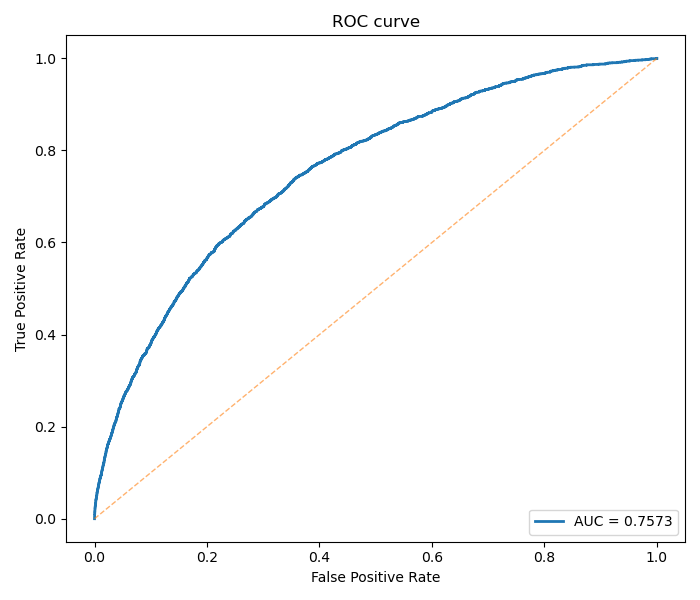


🖼️ Heatmap de correlación:


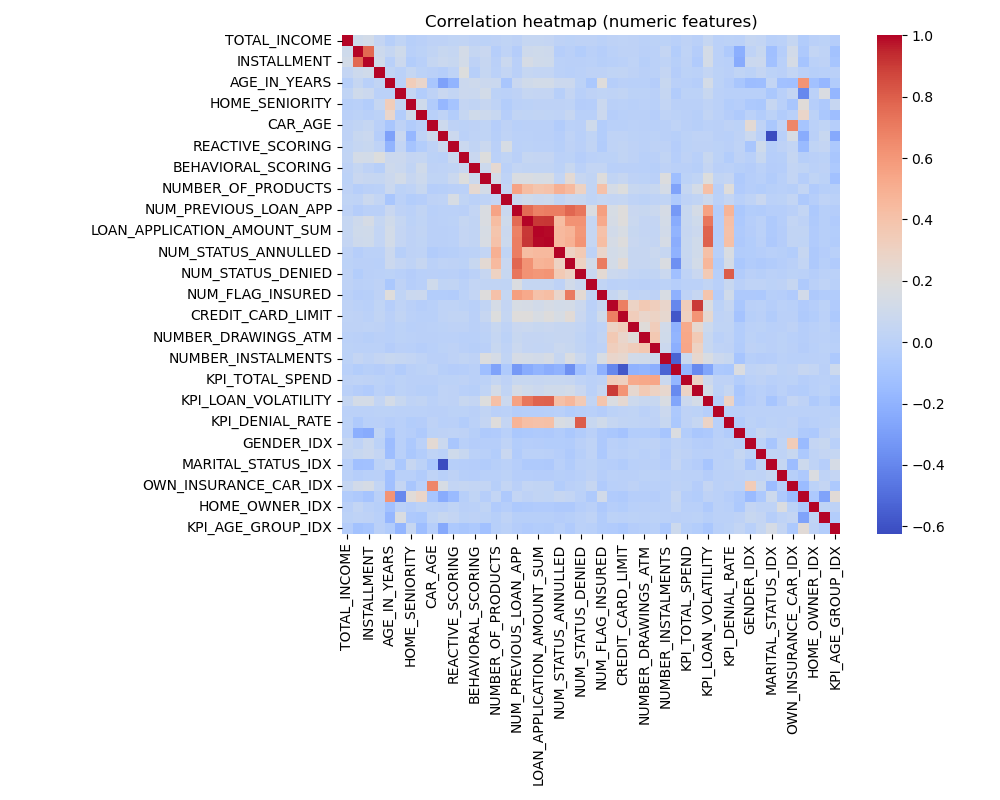


🖼️ Importancia de features:


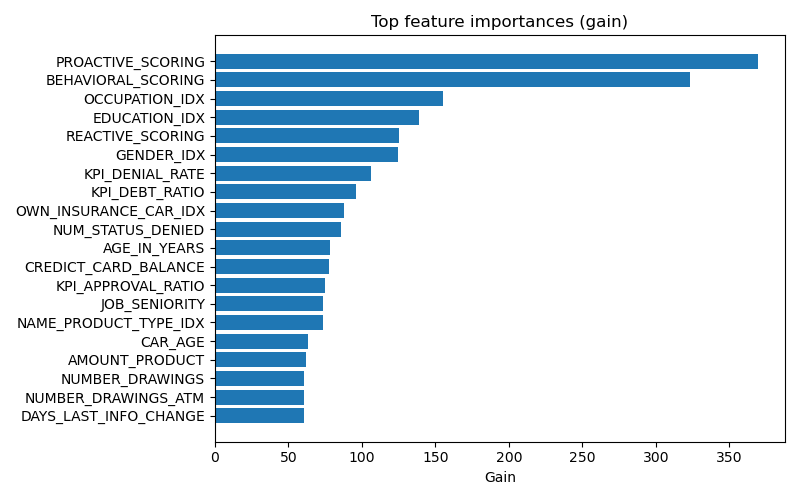


🔍 Vista previa de predicciones:


,actual,prob,pred
0,0,0.350252,0
1,0,0.379254,0
2,0,0.660004,1
3,0,0.157122,0
4,0,0.513371,1
5,0,0.061929,0
6,0,0.138349,0
7,0,0.292261,0
8,0,0.127057,0
9,0,0.225297,0


In [ ]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# ----------------- CONFIG -----------------
MODEL_FILE = "xgb_pipeline_no_earlystop.joblib"
ROC_FILE = "roc_curve.png"
HEATMAP_FILE = "correlation_heatmap.png"
IMP_FILE = "feature_importance.png"
PARQUET_FILE = "/home/jovyan/work/data/curated/Master_Model_FinPlus.parquet"
TARGET_COL = "NON_COMPLIANT_CONTRACT"
# ------------------------------------------


# ==========================
# 1) Ver archivos existentes
# ==========================
print("📁 Archivos en el directorio actual:")
for f in os.listdir():
    print("  -", f)

print("\n✔️ Directorio actual:", os.getcwd())


# ==========================
# 2) Cargar modelo
# ==========================
print("\n📦 Cargando modelo guardado...")
pipeline = joblib.load(MODEL_FILE)
print("Modelo cargado correctamente:\n", pipeline)


# ==========================
# 3) Cargar dataset y predecir
# ==========================
print("\n📄 Cargando dataset...")
df = pd.read_parquet(PARQUET_FILE)
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

print("Dataset cargado. Shape:", df.shape)

print("\n🔮 Generando predicciones...")
y_prob = pipeline.predict_proba(X)[:, 1]
y_pred = pipeline.predict(X)

# ==========================
# 4) Métricas
# ==========================
print("\n📊 Métricas del modelo:")
print("AUC:", roc_auc_score(y, y_prob))
print("\nClassification Report:\n", classification_report(y, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred))


# ==========================
# 5) Mostrar imágenes guardadas
# ==========================
def mostrar_imagen(path, titulo):
    if os.path.exists(path):
        print(f"\n🖼️ {titulo}:")
        display(Image(filename=path))
    else:
        print(f"⚠️ No se encontró {path}")

mostrar_imagen(ROC_FILE, "Curva ROC")
mostrar_imagen(HEATMAP_FILE, "Heatmap de correlación")
mostrar_imagen(IMP_FILE, "Importancia de features")


# ==========================
# 6) Vista previa de predicciones
# ==========================
print("\n🔍 Vista previa de predicciones:")
preview = pd.DataFrame({
    "actual": y,
    "prob": y_prob,
    "pred": y_pred
})
display(preview.head(10))


In [ ]:
# Agrega estas importaciones al inicio del archivo
import h5py
import json
import pickle
import io
from datetime import datetime

# ---- crear archivo H5 con datos y resultados (incluyendo el modelo) ----
import h5py
import json
import pickle
import io
from datetime import datetime

H5_FILE = "model_data_results.h5"

# Crear archivo HDF5
with h5py.File(H5_FILE, 'w') as h5f:
    # Guardar conjuntos de datos procesados
    h5f.create_dataset('X_train', data=X_train_proc, compression='gzip')
    h5f.create_dataset('y_train', data=y_train.values, compression='gzip')
    h5f.create_dataset('X_val', data=X_val_proc, compression='gzip')
    h5f.create_dataset('y_val', data=y_val.values, compression='gzip')
    h5f.create_dataset('X_test', data=X_test_proc, compression='gzip')
    h5f.create_dataset('y_test', data=y_test.values, compression='gzip')
    
    # Guardar predicciones
    h5f.create_dataset('y_prob_test', data=y_prob, compression='gzip')
    h5f.create_dataset('y_pred_test', data=y_pred, compression='gzip')
    
    # Guardar el modelo XGBoost en formato binario dentro del H5
    # Opción 1: Usando el método save_model de XGBoost
    model_buffer = io.BytesIO()
    best_model.get_booster().save_model(model_buffer)
    model_buffer.seek(0)
    model_bytes = model_buffer.read()
    
    # Crear dataset para el modelo binario
    h5f.create_dataset('xgb_model_binary', data=np.void(model_bytes), dtype='V1')
    
    # Opción 2: También guardar el pipeline completo serializado
    pipeline_buffer = io.BytesIO()
    joblib.dump(final_pipeline, pipeline_buffer)
    pipeline_buffer.seek(0)
    pipeline_bytes = pipeline_buffer.read()
    
    h5f.create_dataset('pipeline_joblib', data=np.void(pipeline_bytes), dtype='V1')
    
    # Guardar hiperparámetros del modelo
    h5f.create_dataset('best_params', data=json.dumps(rs.best_params_))
    
    # Guardar nombres de características
    dt = h5py.string_dtype(encoding='utf-8')
    feature_names_ds = h5f.create_dataset('feature_names', (len(proc_feature_names),), dtype=dt)
    for i, name in enumerate(proc_feature_names):
        feature_names_ds[i] = name
    
    # Guardar nombres de columnas originales
    original_cols = X.columns.tolist()
    original_cols_ds = h5f.create_dataset('original_columns', (len(original_cols),), dtype=dt)
    for i, col in enumerate(original_cols):
        original_cols_ds[i] = col
    
    # Guardar nombres de columnas numéricas y categóricas
    num_cols_ds = h5f.create_dataset('numeric_columns', (len(num_cols),), dtype=dt)
    for i, col in enumerate(num_cols):
        num_cols_ds[i] = col
    
    cat_cols_ds = h5f.create_dataset('categorical_columns', (len(cat_cols),), dtype=dt)
    for i, col in enumerate(cat_cols):
        cat_cols_ds[i] = col
    
    # Guardar métricas como atributos
    h5f.attrs['auc'] = float(auc)
    h5f.attrs['approval_threshold'] = float(APPROVAL_THRESHOLD)
    h5f.attrs['scale_pos_weight'] = float(scale_pos_weight)
    h5f.attrs['random_state'] = int(RANDOM_STATE)
    h5f.attrs['creation_date'] = datetime.now().isoformat()
    h5f.attrs['model_type'] = 'XGBoost'
    h5f.attrs['target_column'] = TARGET_COL
    h5f.attrs['file_path'] = FILE_PATH
    
    # Guardar configuración del preprocesador
    h5f.attrs['preprocessor_num_strategy'] = 'median'
    h5f.attrs['preprocessor_cat_strategy'] = 'constant'
    
    # Guardar matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    h5f.create_dataset('confusion_matrix', data=cm, compression='gzip')
    
    # Guardar curva ROC
    h5f.create_dataset('roc_fpr', data=fpr, compression='gzip')
    h5f.create_dataset('roc_tpr', data=tpr, compression='gzip')
    
    # Guardar importancia de características si está disponible
    try:
        fmap = best_model.get_booster().get_score(importance_type="gain")
        importance_indices = []
        importance_values = []
        for k, v in fmap.items():
            idx = int(k[1:])
            importance_indices.append(idx)
            importance_values.append(v)
        
        h5f.create_dataset('feature_importance_indices', data=importance_indices, compression='gzip')
        h5f.create_dataset('feature_importance_values', data=importance_values, compression='gzip')
    except Exception:
        print("No se pudo guardar la importancia de características en H5")

print(f"Archivo H5 guardado en: {H5_FILE}")

# Función para cargar el modelo desde el archivo H5
def load_model_from_h5(filepath):
    """Carga el modelo XGBoost desde un archivo H5"""
    with h5py.File(filepath, 'r') as h5f:
        # Cargar modelo binario
        model_bytes = h5f['xgb_model_binary'][()].tobytes()
        model_buffer = io.BytesIO(model_bytes)
        
        # Crear nuevo modelo XGBoost
        loaded_model = XGBClassifier()
        loaded_model.load_model(model_buffer)
        
        # Cargar parámetros
        params = json.loads(h5f['best_params'][()])
        loaded_model.set_params(**params)
        
        return loaded_model

# Función para cargar el pipeline completo desde el archivo H5
def load_pipeline_from_h5(filepath):
    """Carga el pipeline completo desde un archivo H5"""
    with h5py.File(filepath, 'r') as h5f:
        # Cargar pipeline serializado
        pipeline_bytes = h5f['pipeline_joblib'][()].tobytes()
        pipeline_buffer = io.BytesIO(pipeline_bytes)
        
        loaded_pipeline = joblib.load(pipeline_buffer)
        return loaded_pipeline

# Función para verificar el contenido del archivo H5
def inspect_h5_file(filepath):
    """Inspecciona el contenido del archivo H5"""
    print(f"\n📊 Contenido del archivo H5 '{filepath}':")
    with h5py.File(filepath, 'r') as h5f:
        print("  Datasets:")
        for key in h5f.keys():
            if isinstance(h5f[key], h5py.Dataset):
                shape = h5f[key].shape
                dtype = h5f[key].dtype
                print(f"    - {key}: shape={shape}, dtype={dtype}")
        
        print("\n  Atributos:")
        for attr in h5f.attrs:
            value = h5f.attrs[attr]
            if isinstance(value, str) and len(value) > 100:
                print(f"    - {attr}: {value[:100]}...")
            else:
                print(f"    - {attr}: {value}")

# Mostrar información del archivo H5 creado
inspect_h5_file(H5_FILE)

# Verificar que el modelo se puede cargar desde el H5
print("\n🔍 Verificando que el modelo se puede cargar desde el H5...")
try:
    loaded_xgb_model = load_model_from_h5(H5_FILE)
    print(f"Modelo XGBoost cargado correctamente desde H5")
    print(f"Parámetros del modelo: {loaded_xgb_model.get_params()}")
except Exception as e:
    print(f"Error al cargar el modelo desde H5: {e}")

# Verificar que el pipeline se puede cargar desde el H5
print("\n🔍 Verificando que el pipeline se puede cargar desde el H5...")
try:
    loaded_pipeline = load_pipeline_from_h5(H5_FILE)
    print(f"Pipeline completo cargado correctamente desde H5")
    print(f"Componentes del pipeline: {loaded_pipeline.named_steps}")
except Exception as e:
    print(f"Error al cargar el pipeline desde H5: {e}")


    # ==========================
# 8) Verificar modelo desde H5
# ==========================
H5_FILE = "model_data_results.h5"
if os.path.exists(H5_FILE):
    print(f"\n🧪 Probando modelo cargado desde H5...")
    
    # Cargar el modelo desde H5
    with h5py.File(H5_FILE, 'r') as h5f:
        # Cargar modelo binario
        model_bytes = h5f['xgb_model_binary'][()].tobytes()
        model_buffer = io.BytesIO(model_bytes)
        
        # Crear y cargar modelo
        xgb_model_from_h5 = XGBClassifier()
        xgb_model_from_h5.load_model(model_buffer)
        
        # Cargar datos de prueba
        X_test_h5 = h5f['X_test'][:]
        y_test_h5 = h5f['y_test'][:]
        
        # Hacer predicciones
        y_prob_h5 = xgb_model_from_h5.predict_proba(X_test_h5)[:, 1]
        auc_h5 = roc_auc_score(y_test_h5, y_prob_h5)
        
        print(f"AUC del modelo cargado desde H5: {auc_h5:.4f}")
        
        # Comparar con el modelo original
        print(f"AUC del modelo original: {auc:.4f}")
        print(f"Diferencia: {abs(auc - auc_h5):.6f}")
else:
    print(f"\n⚠️ Archivo H5 no encontrado: {H5_FILE}")